## Project 2
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)


1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

### The Dataset

In this project, we'll examine the structure of a bipartite network of social groups hosted on the Nashville, TN hub of **Meetup.org**.  This dataset is available from: https://www.kaggle.com/stkbailey/nashville-meetup.

#### Read in the data

In [12]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx 

In [18]:
#read in member_to_group_edges.csv to pd dataframe from github repo
mem2grp_edges = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/main/NashvilleSocial/member-to-group-edges.csv")

#read in meta-events.csv to pd dataframe from github repo
meta_events = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/main/NashvilleSocial/meta-events.csv")

#read in meta-groups.csv to pd dataframe from github repo
meta_groups = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/main/NashvilleSocial/meta-groups.csv")

#### Create a basic networkX graph, and examine its structure

In [17]:
G = nx.from_pandas_dataframe(mem2grp_edges, source="member_id", target="group_id",
                                  edge_attr=["weight"])

In [15]:
members = set(mem2grp_edges.member_id.values)
groups = set(mem2grp_edges.group_id.values)

print("There are ", len(groups), " groups.")
print("There are ", len(members), " members.")

There are  602  groups.
There are  24631  members.


In [11]:
nx.is_bipartite(G)

True

In [12]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 25233
Number of edges: 45583
Average degree:   3.6130


### The Bipartite Projection
Then we create weighted bipartite projection graphs. This weight is the number of shared neighbors. In this project, we'll focus on the projection onto groups, where the weight of edges between groups will show us the number of shared members. 

We'll also assign the values from each bipartite projection graph's corresponding metadata table as attributes to its nodes, which will come in handy later when we're analyzing the structure and Centrality measures. *(Adapted from source: https://stackoverflow.com/questions/54497929/networkx-setting-node-attributes-from-dataframe/54662176)*.

We'll also print an example node, to show how the attributes form a dictionary that can be called by the node's ID.

In [20]:
Gr = nx.bipartite.weighted_projected_graph(G, groups)
Gr_node_attr = meta_groups.set_index('group_id').to_dict('index')

for n in Gr.nodes_iter(): Gr.node[n]['name'] = 'None'
for key, value in Gr_node_attr.items(): 
        Gr.node[key]['name'] = value['group_name']
        Gr.node[key]['num_members'] = value['num_members']
        Gr.node[key]['category_name'] = value['category_name']

Gr.node[339011]

{'name': 'Nashville Hiking Meetup',
 'num_members': 15838,
 'category_name': 'Outdoors & Adventure'}

#### Graph the Network

Taking a first look, we see that this network is highly concentrated between connected groups at its center, and surrounded by unconnected groups at its extremities.  We're going to need to use some of the tools we've learned to dive down into zoom in for a more interesting picture.

In this first graph, and throughout this project, we're going to color nodes by the group's `category_name` attribute to see if any immediate insights from that variable jump out.  *(adapted from source: https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt)*

C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


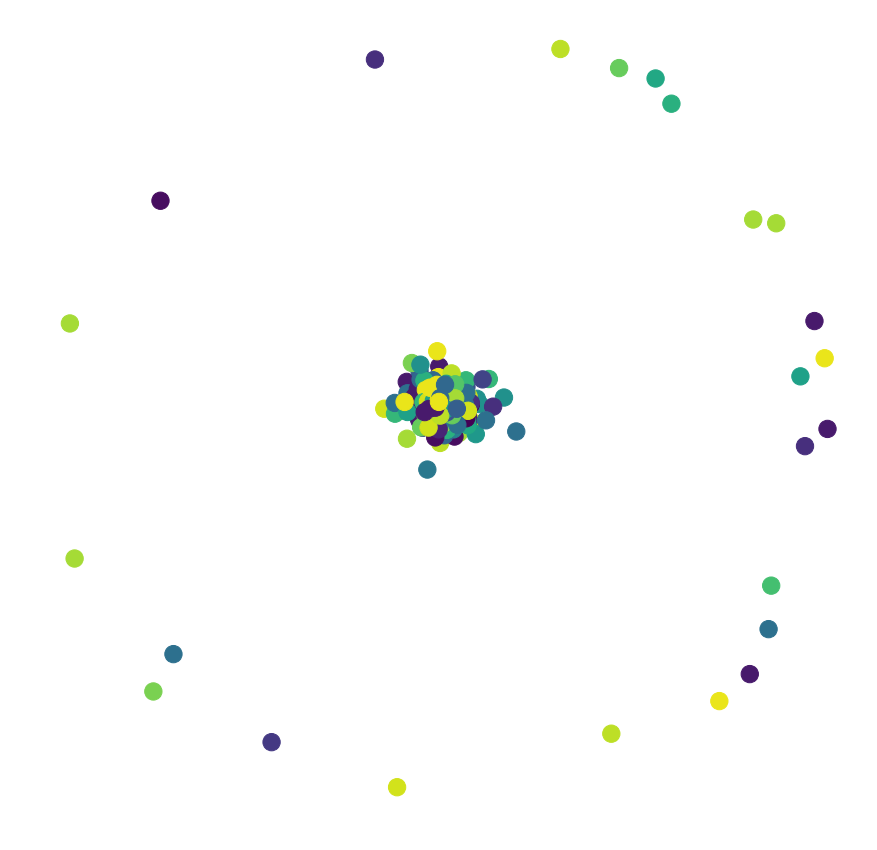

In [22]:
# create number for each group to allow use of colormap
from itertools import count
import math

# get unique groups
groups = set(nx.get_node_attributes(Gr,'category_name').values())
mapping = dict(zip(sorted(groups),count()))
nodes = Gr.nodes()
colors = [mapping[Gr.node[n]['category_name']] for n in nodes]
weights=[math.log(edata['weight']) for f, t, edata in Gr.edges(data=True)]

#initialize the figure
plt.figure(figsize = (15, 15))
ax = plt.subplot()

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(Gr)
ec = nx.draw_networkx_edges(Gr, pos, ax=ax, alpha=0.2, width=weights)
nc = nx.draw_networkx_nodes(Gr, pos, ax=ax, nodelist=nodes, node_color=colors)

plt.axis('off')
plt.show()

##### Island Method

The method we'll use to reduce irrelevant nodes and edges from our network is, of course the Island Method.

We can take the two functions comprising the island method from the textbook, Social Network Analysis For Startups, pages 62 - 64 and available [here](https://www.oreilly.com/library/view/social-network-analysis/9781449311377/ch04.html). 

In [27]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2

In [28]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

#### Using the Island Method

We'll start by using the Island Method function on the largest of the Network's connected component subgraphs.

In [29]:
cc = list(nx.connected_component_subgraphs(Gr))

In [30]:
islands = island_method(cc[0])

In [31]:
for i in islands: 
    # print the threshold level, size of the graph, and number of connected components
    print("Threshold:", i[0], ", Size of graph:", len(i[1]), ", Number of connected components:", len(list(nx.connected_component_subgraphs(i[1]))))

Threshold: 1 , Size of graph: 472 , Number of connected components: 2
Threshold: 43 , Size of graph: 63 , Number of connected components: 5
Threshold: 85 , Size of graph: 23 , Number of connected components: 4
Threshold: 127 , Size of graph: 12 , Number of connected components: 3
Threshold: 169 , Size of graph: 2 , Number of connected components: 1


Let's view our graph at the first threshold, trimming away just one level of extraneous edges.  We have a graph with 472 nodes, and 2 connected components (but we see that the majority of these nodes are within a single large cluster).  We're still zoomed out too far to make any solid conclusions about this Network.


In [32]:
for n in islands[0][1].nodes_iter(): islands[0][1].node[n]['name'] = 'None'
for key, value in Gr_node_attr.items():
    if key in islands[0][1].nodes():
        islands[0][1].node[key]['name'] = value['group_name']
        islands[0][1].node[key]['num_members'] = value['num_members']
        islands[0][1].node[key]['category_name'] = value['category_name']
    else:
        continue

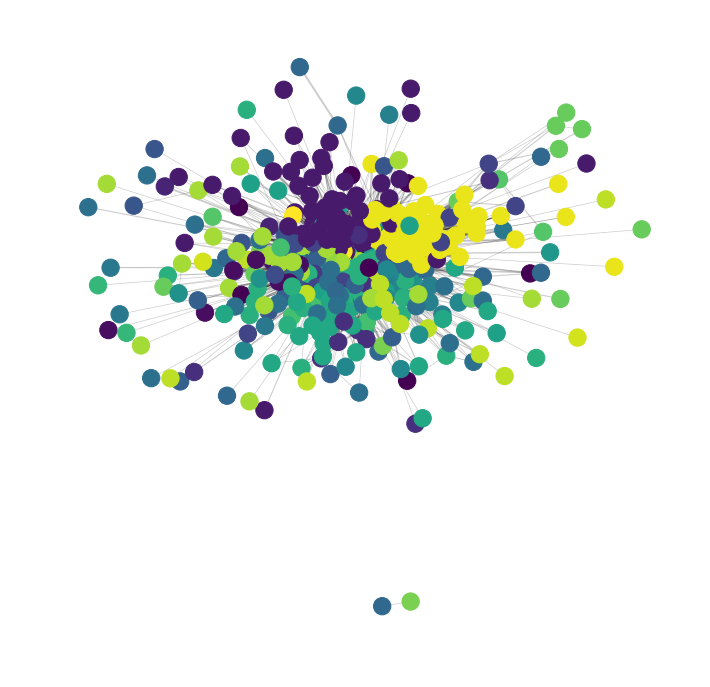

In [38]:
# create number for each group to allow use of colormap
from itertools import count
import math

# get unique groups
groups = set(nx.get_node_attributes(islands[0][1],'category_name').values())
mapping = dict(zip(sorted(groups),count()))
nodes = islands[0][1].nodes()
colors = [mapping[islands[0][1].node[n]['category_name']] for n in nodes]
weights=[math.log(edata['weight']) for f, t, edata in islands[0][1].edges(data=True)]

#initialize the figure
plt.figure(figsize = (12, 12))
ax = plt.subplot()

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(islands[0][1])
ec = nx.draw_networkx_edges(islands[0][1], pos, ax=ax, alpha=0.2, width=weights)
nc = nx.draw_networkx_nodes(islands[0][1], pos, ax=ax, nodelist=nodes, node_color=colors)

plt.axis('off')
plt.show()

Let`s jump to the next threshold.  We see that at the threshold 43, we get a graph with 63 nodes and 5 connected component subgraphs - but we can immediately see that two of these subgraphs are where most of the action is happening!

In [34]:
for n in islands[1][1].nodes_iter(): islands[1][1].node[n]['name'] = 'None'
for key, value in Gr_node_attr.items():
    if key in islands[1][1].nodes():
        islands[1][1].node[key]['name'] = value['group_name']
        islands[1][1].node[key]['num_members'] = value['num_members']
        islands[1][1].node[key]['category_name'] = value['category_name']
    else:
        continue

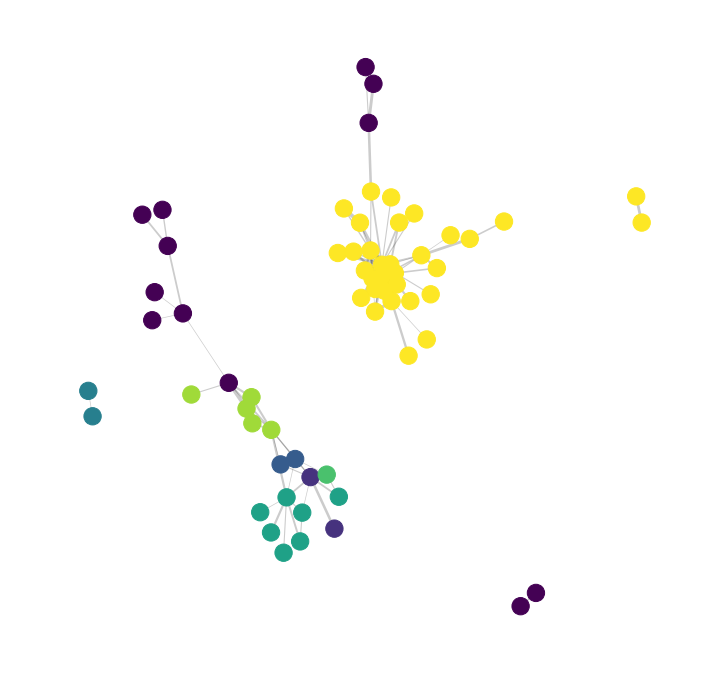

In [37]:
# get unique groups
groups = set(nx.get_node_attributes(islands[1][1],'category_name').values())
mapping = dict(zip(sorted(groups),count()))
nodes = islands[1][1].nodes()
colors = [mapping[islands[1][1].node[n]['category_name']] for n in nodes]
weights=[math.log(edata['weight']) for f, t, edata in islands[0][1].edges(data=True)]

#initialize the figure
plt.figure(figsize = (12, 12))
ax = plt.subplot()

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(islands[1][1])
ec = nx.draw_networkx_edges(islands[1][1], pos, ax=ax, alpha=0.2, width=weights)
nc = nx.draw_networkx_nodes(islands[1][1], pos, ax=ax, nodelist=nodes, node_color=colors)

plt.axis('off')
plt.show()

We have two subgraphs, one which is predominantly composed of groups having the same category, and another which contains groups of 5 categories.  We'll take a look first at the subgraph with a diversity of group categories.

We can see that the network is most connected by **Eat, Love, Nash** - a general 'socializing' group, as well as 3 groups which serve to introduce the wider network to a distinct category: **Nashville Hiking Meetup** in the *Outdoors & Adventure* category; **Nashville Young Professionals Meetup** in the *Career & Business* category; and **Stepping Out!** in the *Dancing* category.

When we look at the measure of these nodes' influence on the network it is clear that their influence is felt not merely by virtue of their size, but as or more importantly by the high **betweenness** centrality - their role in introducing disparate groups to the wider social and networking scene.


In [54]:
ccGr = list(nx.connected_component_subgraphs(islands[1][1]))

In [40]:
for i in ccGr:
    for n in i.nodes_iter(): i.node[n]['name'] = 'None'
    for key, value in Gr_node_attr.items():
        if key in i.nodes():
            i.node[key]['name'] = value['group_name']
            i.node[key]['num_members'] = value['num_members']
            i.node[key]['category_name'] = value['category_name']
        else:
            continue

C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


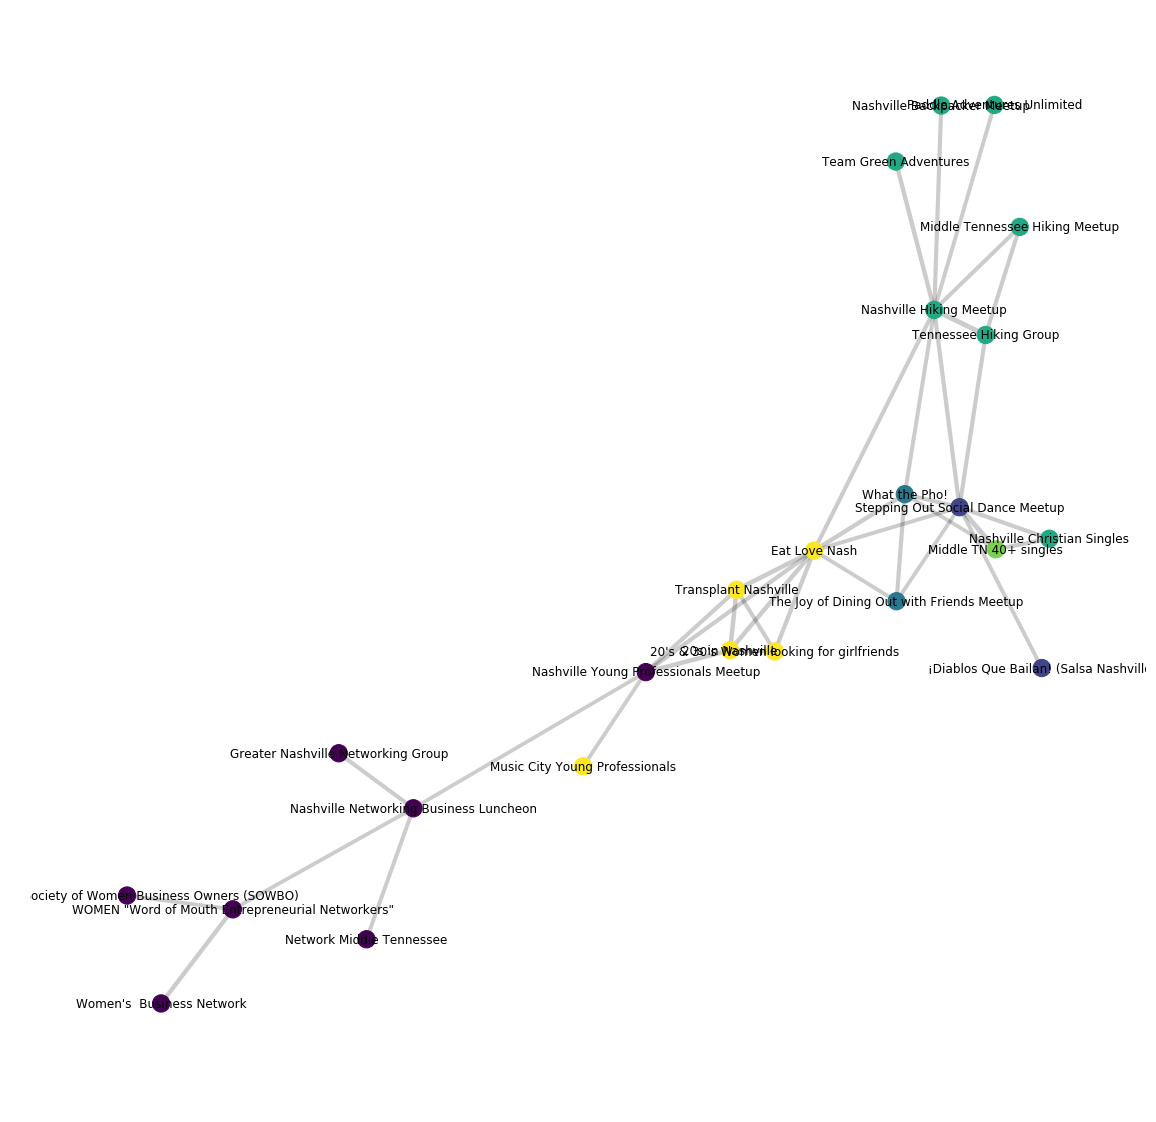

In [62]:
# get unique groups
groups1 = set(nx.get_node_attributes(ccGr[0],'category_name').values())
mapping1 = dict(zip(sorted(groups1),count()))
nodes1 = ccGr[0].nodes()
colors1 = [mapping1[ccGr[0].node[n]['category_name']] for n in nodes1]
weights1 = [math.log(edata['weight']) for f, t, edata in ccGr[0].edges(data=True)]
labels1 = dict(zip(nodes1, [ccGr[0].node[i]['name'] for i in nodes1]))

#initialize the figure
plt.figure(figsize=(20, 20))
ax1 = plt.subplot()
plt.axis('off')

# drawing nodes and edges separately so we can capture collection for colobar
pos1 = nx.spring_layout(ccGr[0])
ec = nx.draw_networkx_edges(ccGr[0], pos1, ax=ax1, alpha=0.2, width=weights1)
nc = nx.draw_networkx_nodes(ccGr[0], pos1, ax=ax1, nodelist=nodes1, node_color=colors1)
lc = nx.draw_networkx_labels(ccGr[0], pos1, labels=labels1, ax=ax1)

In [51]:
def sorted_map(dd: dict) -> dict:
    """
    Sorts dict by its values (desc)
    
    :param dd: dictionary with numeric values
    :return sorted dictionary ordered by its numeric value
    """
    sorted_dict = sorted(dd.items(), key=lambda x: (-x[1], x[0]))
    sorted_dict = [(x[0], round(x[1], 2)) for x in sorted_dict]
    return sorted_dict

In [126]:
d = nx.degree_centrality(ccGr[0])
dsm = sorted_map(d)

c = nx.closeness_centrality(ccGr[0])
csm = sorted_map(c)

b = nx.betweenness_centrality(ccGr[0])
bsm = sorted_map(b)

ident1 = [x[0] for x in dsm[:15]]
ident2 = [x[0] for x in csm[:15]]
ident3 = [x[0] for x in bsm[:15]]
ident = list(set(ident1) | set(ident2) | set(ident3))

summary_df = pd.DataFrame({'GroupID': ident,
    'Category': [ccGr[0].node[i]['category_name'] for i in ident],
    'Group Name': [ccGr[0].node[i]['name'] for i in ident],
    
    'Degree Centrality': [d[i] for i in ident],
    'Closeness': [c[i] for i in ident], 
    'Betweenness': [b[i] for i in ident]})


summary_df['Sum Centrality'] = sum([summary_df['Degree Centrality'],
                                   summary_df.Closeness,
                                   summary_df.Betweenness])

print('\n\n================== Most Central Nodes, ccGr[0] ================\n\n')
summary_df.sort_values(by='Sum Centrality', ascending=False)



================== Most Central Nodes, ccGr[0] ================




GroupID              Category  \
16  18955830           Socializing   
0   18562307     Career & Business   
1     339011  Outdoors & Adventure   
4   19728145               Dancing   
8   19266390     Career & Business   
2    1187715          Food & Drink   
10  18506072           Socializing   
7   19713173           Socializing   
6    4705492     Career & Business   
9    1371991          Food & Drink   
11  21174496           Socializing   
13   1585196  Outdoors & Adventure   
15  18243826               Singles   
3   18495240  Outdoors & Adventure   
17  18297014  Outdoors & Adventure   
12  20807142           Socializing   
5    1102353  Outdoors & Adventure   
14    526316               Dancing   
18    929402  Outdoors & Adventure   

                                          Group Name  Degree Centrality  \
16                                     Eat Love Nash           0.347826   
0               Nashville Young Professionals Meetup           0.217391   
1                            Nashville Hiking Meetup           0.347826   
4                   Stepping Out Social Dance Meetup           0.347826   
8             Nashville Networking Business Luncheon           0.173913   
2                                      What the Pho!           0.217391   
10                                  20s in Nashville           0.173913   
7                               Transplant Nashville           0.173913   
6   WOMEN "Word of Mouth Entrepreneurial Networkers"           0.130435   
9          The Joy of Dining Out with Friends Meetup           0.130435   
11         20's & 30's Women looking for girlfriends           0.130435   
13                            Tennessee Hiking Group           0.130435   
15                             Middle TN 40+ singles           0.130435   
3                     Middle Tennessee Hiking Meetup           0.086957   
17                       Nashville Christian Singles           0.086957   
12                    Music City Young Professionals           0.043478   
5                        Nashville Backpacker Meetup           0.043478   
14            ¡Diablos Que Bailan! (Salsa Nashville)           0.043478   
18                       Paddle Adventures Unlimited           0.043478   

    Closeness  Betweenness  Sum Centrality  
16   0.511111     0.538538        1.397475  
0    0.450980     0.466403        1.134775  
1    0.442308     0.337615        1.127749  
4    0.442308     0.241107        1.031240  
8    0.365079     0.383399        0.922392  
2    0.418182     0.041173        0.676746  
10   0.403509     0.010540        0.587962  
7    0.403509     0.010540        0.587962  
6    0.283951     0.169960        0.584346  
9    0.377049     0.000000        0.507484  
11   0.353846     0.000000        0.484281  
13   0.338235     0.008235        0.476905  
15   0.319444     0.001976        0.451856  
3    0.315068     0.000000        0.402025  
17   0.315068     0.000000        0.402025  
12   0.315068     0.000000        0.358547  
5    0.310811     0.000000        0.354289  
14   0.310811     0.000000        0.354289  
18   0.310811     0.000000        0.354289

What of the second subgraph?  We see that the groups here are overwhelmingly from the *Tech* category, connected to a single triad of the tech specific *Career & Business* networking groups.  

There is less concentration in the degree centrality in this group - the top 6 groups have higher degree centrality than the **Eat, Love, Nash** group in our previous network, for example.

But there is a clear winner when it comes to betweenness in this group - the **Nashville JS** group appears to play an outsize role in connecting the other groups in the tech commununity to the greater network.

C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\tsfra\py_oh_my\anaconda3\envs\sps620env\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


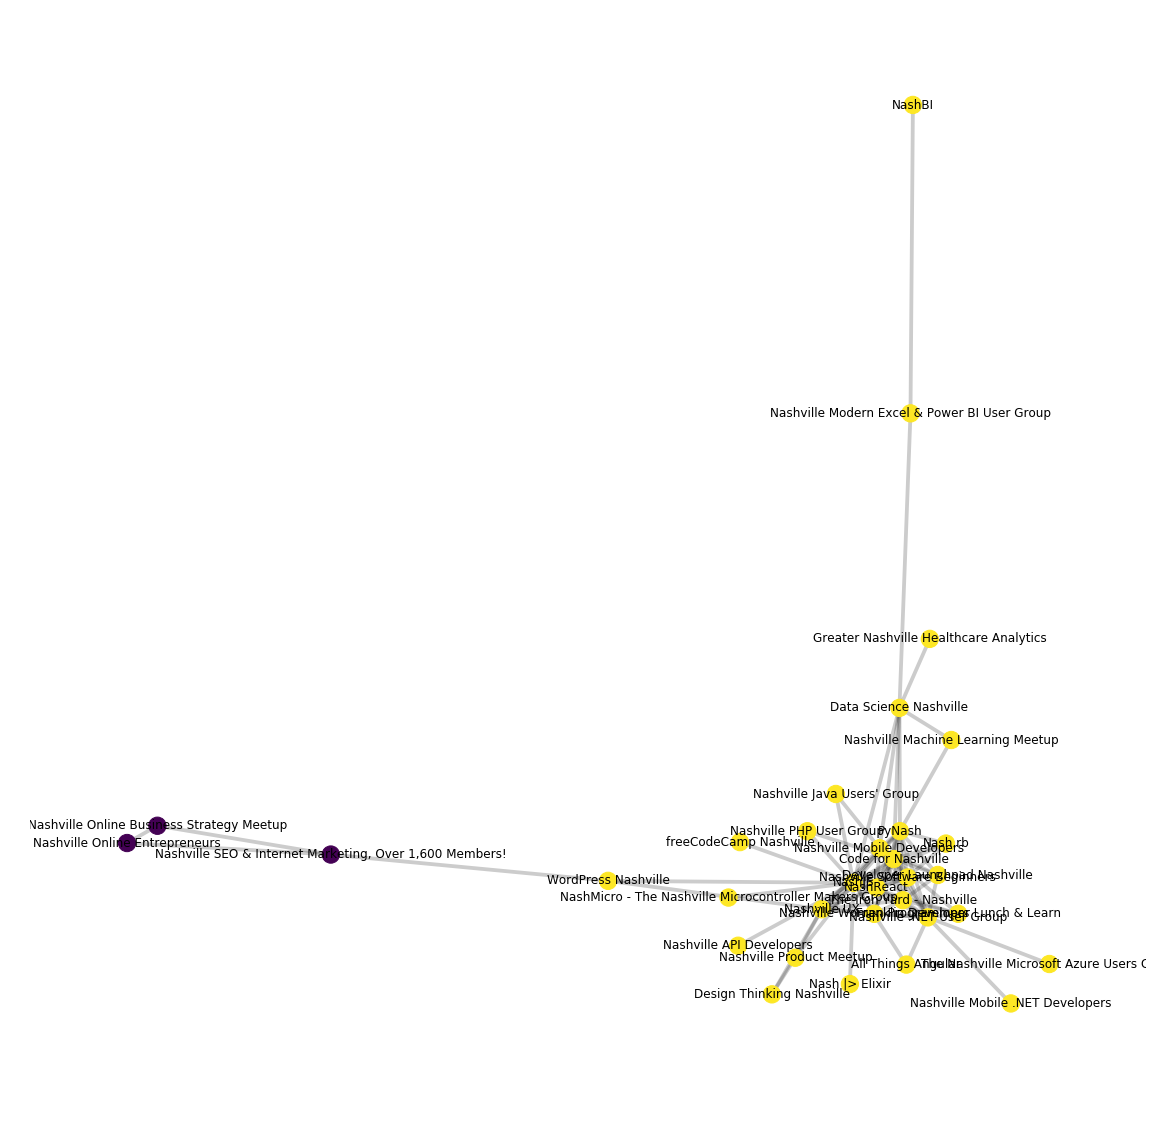

In [69]:
#get unique groups
groups2 = set(nx.get_node_attributes(ccGr[3],'category_name').values())
mapping2 = dict(zip(sorted(groups2),count()))
nodes2 = ccGr[3].nodes()
colors2 = [mapping2[ccGr[3].node[n]['category_name']] for n in nodes2]
weights2 = [math.log(edata['weight']) for f, t, edata in ccGr[2].edges(data=True)]
labels2 = dict(zip(nodes2, [ccGr[3].node[i]['name'] for i in nodes2]))

#initialize the figure
plt.figure(figsize=(20, 20))
ax2 = plt.subplot()
plt.axis('off')

# drawing nodes and edges separately so we can capture collection for colobar
pos2 = nx.spring_layout(ccGr[3])
ec = nx.draw_networkx_edges(ccGr[3], pos2, ax=ax2, alpha=0.2, width=weights2)
nc = nx.draw_networkx_nodes(ccGr[3], pos2, ax=ax2, nodelist=nodes2, node_color=colors2)
lc = nx.draw_networkx_labels(ccGr[3], pos2, labels=labels2, ax=ax2)

In [68]:
d = nx.degree_centrality(ccGr[3])
dsm = sorted_map(d)

c = nx.closeness_centrality(ccGr[3])
csm = sorted_map(c)

b = nx.betweenness_centrality(ccGr[3])
bsm = sorted_map(b)

ident1 = [x[0] for x in dsm[:15]]
ident2 = [x[0] for x in csm[:15]]
ident3 = [x[0] for x in bsm[:15]]
ident = list(set(ident1) | set(ident2) | set(ident3))

summary_df = pd.DataFrame({'GroupID': ident,
    'Category': [ccGr[3].node[i]['category_name'] for i in ident],
    'Group Name': [ccGr[3].node[i]['name'] for i in ident],
    'Degree Centrality': [d[i] for i in ident],
    'Closeness': [c[i] for i in ident], 
    'Betweenness': [b[i] for i in ident]})


summary_df['Sum Centrality'] = sum([summary_df['Degree Centrality'],
                                   summary_df.Closeness,
                                   summary_df.Betweenness])

print('\n\n=========================== Most Central Nodes, ccGr[3] =========================\n\n')
summary_df.sort_values(by='Sum Centrality', ascending=False)



=========================== Most Central Nodes, ccGr[3] =========================




GroupID           Category  \
15  10016242               Tech   
9   16477792               Tech   
3   16487812               Tech   
12  11625832               Tech   
13   7836842               Tech   
1   10178242               Tech   
4    6707902               Tech   
17   7130232               Tech   
8   18494105               Tech   
11   1728035               Tech   
10  18850080               Tech   
14  19997487               Tech   
18   9376702               Tech   
7   18616278               Tech   
0     535553               Tech   
5    1776274  Career & Business   
16  15297782               Tech   
6   13560402               Tech   
2    1358081  Career & Business   

                                           Group Name  Degree Centrality  \
15                                             NashJS            0.68750   
9                           Nashville .NET User Group            0.43750   
3                                  Code for Nashville            0.43750   
12                                             PyNash            0.40625   
13                                       Nashville UX            0.37500   
1                         Nashville Mobile Developers            0.34375   
4                              Data Science Nashville            0.21875   
17                       Nashville Software Beginners            0.31250   
8                           The Iron Yard - Nashville            0.31250   
11                                WordPress Nashville            0.09375   
10                                          NashReact            0.21875   
14                      Developer Launchpad Nashville            0.21875   
18                        Nashville Women Programmers            0.18750   
7                    Franklin Developer Lunch & Learn            0.12500   
0                                             Nash.rb            0.12500   
5   Nashville SEO & Internet Marketing, Over 1,600...            0.09375   
16                           Nashville Product Meetup            0.09375   
6        Nashville Modern Excel & Power BI User Group            0.06250   
2           Nashville Online Business Strategy Meetup            0.06250   

    Closeness  Betweenness  Sum Centrality  
15   0.711111     0.514118        1.912729  
9    0.542373     0.141487        1.121360  
3    0.571429     0.059497        1.068426  
12   0.561404     0.071527        1.039180  
13   0.551724     0.109915        1.036639  
1    0.542373     0.034699        0.920822  
4    0.492308     0.193212        0.904270  
17   0.507937     0.005600        0.826036  
8    0.507937     0.005379        0.825815  
11   0.470588     0.175403        0.739741  
10   0.484848     0.000000        0.703598  
14   0.477612     0.000000        0.696362  
18   0.477612     0.000000        0.665112  
7    0.450704     0.000000        0.575704  
0    0.444444     0.000000        0.569444  
5    0.336842     0.120968        0.551560  
16   0.438356     0.009728        0.541834  
6    0.340426     0.062500        0.465426  
2    0.256000     0.000000        0.318500

In [ ]:
ccGr